In [1]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mpl_finance
%matplotlib inline
plt.rcParams['font.family'] = 'IPAPGothic'
from oandapyV20 import API
from oandapyV20.exceptions import V20Error
import oandapyV20.endpoints.instruments as instruments
import oandapyV20.endpoints.accounts as accounts
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.positions as positions
import oandapyV20.endpoints.pricing as pricing
from oandapyV20.endpoints.pricing import PricingInfo
from oandapyV20.contrib.requests import (MarketOrderRequest, StopLossDetails)
import oandapyV20.endpoints.forexlabs as labs
import datetime
from statistics import mean
from statistics import median
import calendar
import datetime
from math import floor
import time
import itertools
from decimal import *

In [2]:
# OANDA API v20の口座IDとAPIトークン
accountID = "101-009-12609641-001"
access_token = "11f2a77cf99d3d29afc4c1cb1a0fb36b-e0fc1d1bf476926157f1d5992466fdf4"
# OANDAのデモ口座へのAPI接続
api = API(access_token=access_token, environment="practice")

In [3]:
# APIから取得したレートをPandasのDataFrameへ
def to_dataframe(r):
    data = []
    for raw in r.response['candles']:
        data.append([raw['time'], raw['volume'], raw['mid']['o'], raw['mid']['h'], raw['mid']['l'], raw['mid']['c']])

    # リストからPandas DataFrameへ変換
    df = pd.DataFrame(data)
    df.columns = ['Time', 'Volume', 'Open', 'High', 'Low', 'Close']
    df['Time'] = pd.to_datetime(df['Time'])
    for col in ['Open', 'High', 'Low', 'Close']:
        df[col] = df[col].apply(float)
    return df

In [4]:
# 第何何曜日（第nX曜日）の日付を返す関数
def get_day_of_nth_dow(year, month, nth, dow):
    '''dow: Monday(0) - Sunday(6)'''
    if nth < 1 or dow < 0 or dow > 6:
        return None

    first_dow, n = calendar.monthrange(year, month)
    day = 7 * (nth - 1) + (dow - first_dow) % 7 + 1

    return day if day <= n else None

In [12]:
def get_data(count, gran, year, month, day, hour, minute, second, inst='USD_JPY'):
    fmt = '%Y-%m-%dT%H:%M:00.000000Z'
    _from = datetime.datetime(year=year, month=month, day=day,
                              hour=hour, minute=minute, second=second).strftime(fmt)
    params = {
        "count": count,
        "granularity": gran,
        'from': _from,
#         'dailyAlignment': 0
    }
    r = instruments.InstrumentsCandles(instrument=inst, params=params)
    api.request(r)
    df = to_dataframe(r)
    return df

In [6]:
def get_data_super(start, end, gran, inst='USD_JPY'):
    f = True
    f_count = 0
    while f:
        try:
            # OANDA API v20の口座IDとAPIトークン
            accountID = "101-009-12609641-001"
            access_token = "11f2a77cf99d3d29afc4c1cb1a0fb36b-e0fc1d1bf476926157f1d5992466fdf4"
            # OANDAのデモ口座へのAPI接続
            api = API(access_token=access_token, environment="practice")
            # xxxx-xx-xx～xxxx-xx-xx の期間のデータを取得してデータフレームを返す
            s_year, s_month, s_day, s_hour, s_minute, s_second = map(int, start.split('-'))
            e_year, e_month, e_day, e_hour, e_minute, e_second = map(int, end.split('-'))
            fmt = '%Y-%m-%dT%H:%M:00.000000Z'
            from_ = datetime.datetime(year=s_year, month=s_month, day=s_day,
                                      hour=s_hour, minute=s_minute, second=s_second).strftime(fmt)
            to_ = datetime.datetime(year=e_year, month=e_month, day=e_day,
                                    hour=e_hour, minute=e_minute, second=e_second).strftime(fmt)
            to_dt = '{}-{}-{} {}:{}:{}'.format(e_year, e_month, e_day, e_hour, e_minute, e_second)
            to_unix = datetime.datetime.strptime(to_dt, '%Y-%m-%d %H:%M:%S').timestamp()
            df = pd.DataFrame()
            # 5000個制限に引っかからなければこっちの処理
            try:
                params = {
                    "granularity": gran,
                    'from': from_,
                    'to': to_
                }
                r = instruments.InstrumentsCandles(instrument=inst, params=params)
                api.request(r)
                df = to_dataframe(r)
                f = False
            # 引っかかればこっちの処理
            except:
                i = True
                while i:
                    df_tmp = get_data(count=5000, gran=gran, year=s_year, month=s_month, day=s_day,
                                     hour=s_hour, minute=s_minute, second=s_second, inst=inst)
                    # ケツが同じなら止める (最新迄用)
                    if df.tail(1).reset_index(drop=True).equals(df_tmp.tail(1).reset_index(drop=True)):
                        i = False
                    else:
                        df = pd.concat([df, df_tmp[:-1]], ignore_index=True)
                        index = df_tmp.tail(1).index[0]
                        s_year = df_tmp.iat[index, 0].year
                        s_month = df_tmp.iat[index, 0].month
                        s_day = df_tmp.iat[index, 0].day
                        s_hour = df_tmp.iat[index, 0].hour
                        s_minute = df_tmp.iat[index, 0].minute
                        s_second = df_tmp.iat[index, 0].second
                        # 5000個ずつ取得してエンドの unix 超えたら止める
                        if to_unix < df.iat[df.tail(1).index[0], 0].timestamp():
                            # はみ出した分をここで切り落とす
                            for i in range(len(df.index) - 5000, len(df.index)):
                                if to_unix <= df.iat[i, 0].timestamp():
                                    df = df[:i]
                                    break
                            i = False
                f = False
        except Exception as e:
            if f_count > 10:
                print(e)
                f = False
            time.sleep(5)
            f_count+=1
            pass
    return df

In [7]:
# バックテスト
def back_test(K, start, end, gran, ref):
    K = K # レンジ幅係数
    range_ = 0
    range_list = []
    ave_range = 0
    least_5 = 0
    pos = 'None'
    profit_list = []
    entry_rate = 0
    pos_count = 0
    fee = 0.008
    ref = ref
    
    df = get_data_super(start, end, gran)
    pos_df = pd.DataFrame(columns=['date', 'entry_rate', 'exit_rate', 'profit'])
    
    # OANDA API v20の口座IDとAPIトークン
    accountID = "101-009-12609641-001"
    access_token = "11f2a77cf99d3d29afc4c1cb1a0fb36b-e0fc1d1bf476926157f1d5992466fdf4"
    # OANDAのデモ口座へのAPI接続
    api = API(access_token=access_token, environment="practice")

    # 実行
    for i in range(len(df.index) - 1):
        rate = df.iat[i, 5] # 当日の終値
        next_rate = df.iat[i+1, 2] # シグナル点灯した次の足の始値
        range_ = round(df.iat[i, 3] - df.iat[i, 4], 3) # High - Low
        range_list.append(range_)
    
        if i > ref:
            least_m = round(mean(range_list[i-ref-1:i-1]) * K, 3)
            open_high = round(df.iat[i, 3] - df.iat[i, 2], 3) # High - Open
            open_low = round(df.iat[i, 2] - df.iat[i, 4], 3) # Open - Low
            # print('least_m: {} open_high: {} open_low: {}'.format(least_m, open_high, open_low))

            # 上昇トレンドと判断しロング
            if least_m < open_high and open_low < open_high:
                if pos == 'entry_long':
                    continue
                else:
                    pos_count+=1
                    # もし逆のポジションを持ってたら利確
                    if pos == 'entry_short':
                        exit_rate = next_rate
                        profit = entry_rate - exit_rate - fee
                        profit_list.append(profit)
#                         print('S利確 entry_rate: {}, exit_rate: {}, profit: {}'.format(entry_rate, exit_rate, profit))
                        tmp_se = pd.Series( [df.iat[i,0], entry_rate, exit_rate, profit ], index=pos_df.columns )
                        pos_df = pos_df.append( tmp_se, ignore_index=True )
                    
                    entry_rate = next_rate
                    pos = 'entry_long'
                    # print(pos)
        
            # 下降トレンドと判断しショート
            if least_m < open_low and open_high < open_low:
                if pos == 'entry_short':
                    continue
                else:
                    pos_count+=1
                    # もし逆のポジションを持ってたら利確
                    if pos == 'entry_long':
                        exit_rate = next_rate
                        profit = exit_rate - entry_rate - fee
                        profit_list.append(profit)
#                         print('L利確 entry_rate: {}, exit_rate: {}, profit: {}'.format(entry_rate, exit_rate, profit))
                        tmp_se = pd.Series( [df.iat[i,0], entry_rate, exit_rate, profit ], index=pos_df.columns )
                        pos_df = pos_df.append( tmp_se, ignore_index=True )
        
                    entry_rate = next_rate
                    pos = 'entry_short'
                    # print(pos)
                    
#     print('posision count: {}, profit: {}'.format(pos_count, sum(profit_list)))
    return pos_count, sum(profit_list), pos_df
#     return pos_count, sum(profit_list)

### 足と係数両方検証

In [12]:
# 2010年から2018年の9年間で検証
foot_gran_k = pd.DataFrame(columns=['K', 'gran', 'pos_count', 'profit'])
for i in range(5, 25+1):
    K = round(i * 0.1, 2)
    for gran in ['M5', 'M10', 'M15', 'M30',
                 'H1', 'H2', 'H3', 'H4', 'H6', 'H8', 'H12',
                 'D']:
        pos_count, profit = back_test(K=K, start='2010-01-01-00-00-00', end='2018-12-31-00-00-00', gran=gran, ref=5)
        print('K: {}, gran: {}, pos_count: {}, profit: {}'.format(K, gran, pos_count, profit))
        tmp_se = pd.Series( [K, gran, pos_count, profit ], index=foot_gran_k.columns )
        foot_gran_k = foot_gran_k.append( tmp_se, ignore_index=True )

K: 0.5, gran: M5, pos_count: 247222, profit: -2245.561000000522
K: 0.5, gran: M10, pos_count: 124848, profit: -1199.4040000002592
K: 0.5, gran: M15, pos_count: 83812, profit: -756.5380000001543
K: 0.5, gran: M30, pos_count: 41003, profit: -361.3320000000545
K: 0.5, gran: H1, pos_count: 20807, profit: -183.20499999998643
K: 0.5, gran: H2, pos_count: 9991, profit: -119.51899999997322
K: 0.5, gran: H3, pos_count: 6646, profit: -38.63000000000875
K: 0.5, gran: H4, pos_count: 5043, profit: -53.19400000000768
K: 0.5, gran: H6, pos_count: 3415, profit: -16.93099999999916
K: 0.5, gran: H8, pos_count: 2508, profit: 37.45199999999967
K: 0.5, gran: H12, pos_count: 1726, profit: 85.31800000000173
K: 0.5, gran: D, pos_count: 923, profit: 5.894000000000514
K: 0.6, gran: M5, pos_count: 209626, profit: -1921.3090000004165
K: 0.6, gran: M10, pos_count: 104396, profit: -1007.9200000002012
K: 0.6, gran: M15, pos_count: 69752, profit: -625.0780000001141
K: 0.6, gran: M30, pos_count: 34017, profit: -284.20

K: 1.6, gran: M5, pos_count: 31333, profit: -312.8880000000461
K: 1.6, gran: M10, pos_count: 14422, profit: -151.593999999983
K: 1.6, gran: M15, pos_count: 9709, profit: -90.417000000011
K: 1.6, gran: M30, pos_count: 5166, profit: 53.891999999998056
K: 1.6, gran: H1, pos_count: 2875, profit: 34.35299999999775
K: 1.6, gran: H2, pos_count: 1478, profit: 2.763000000000633
K: 1.6, gran: H3, pos_count: 940, profit: 21.892000000000134
K: 1.6, gran: H4, pos_count: 694, profit: 41.39899999999969
K: 1.6, gran: H6, pos_count: 490, profit: 66.756
K: 1.6, gran: H8, pos_count: 365, profit: 6.27400000000005
K: 1.6, gran: H12, pos_count: 229, profit: 28.144000000000105
K: 1.6, gran: D, pos_count: 127, profit: -15.441000000000074
K: 1.7, gran: M5, pos_count: 26846, profit: -260.63000000002717
K: 1.7, gran: M10, pos_count: 12288, profit: -120.2299999999873
K: 1.7, gran: M15, pos_count: 8237, profit: -73.77100000001033
K: 1.7, gran: M30, pos_count: 4450, profit: 42.87399999999765
K: 1.7, gran: H1, pos_c

In [13]:
foot_gran_k.sort_values(by='profit', ascending=False).head(10)

,K,gran,pos_count,profit
10,0.5,H12,1726,85.318
114,1.4,H3,1246,83.024
242,2.5,M15,2757,71.763
45,0.8,H8,1430,70.303
22,0.6,H12,1466,70.044
140,1.6,H6,490,66.756
102,1.3,H3,1492,65.152
33,0.7,H8,1756,64.801
103,1.3,H4,1094,59.325
21,0.6,H8,2108,56.418


In [14]:
foot_gran_k.to_csv('foot_gran_k.csv')

In [ ]:
foot_gran_k = pd.read_csv('foot_gran_k.csv')

### 全約定履歴をデータフレームで返すように

### 1 K=0.5, gran='H12'

In [52]:
pos_count, profit, pos_df = back_test(K=0.5, start='2010-01-01-00-00-00', end='2018-12-31-00-00-00', gran='H12', ref=5)
print('pos_count: {}, profit: {}'.format(pos_count, profit))

pos_count: 1726, profit: 85.31800000000173


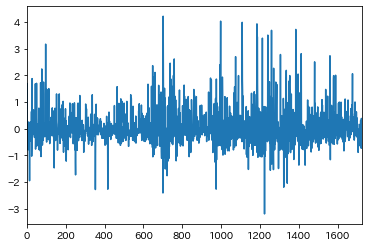

In [53]:
pos_df['profit'].plot()

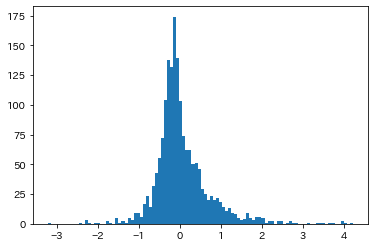

In [54]:
plt.hist(pos_df['profit'], bins=100)
plt.show()

In [55]:
pos_df.describe()

,entry_rate,exit_rate,profit
count,1725.000000,1725.000000,1725.000000
mean,99.006256,99.016991,0.049460
std,14.742952,14.744837,0.676435
min,75.888000,75.888000,-3.202000
25%,82.838000,82.838000,-0.293000
50%,101.920000,101.922000,-0.085000
75%,111.576000,111.576000,0.279000
max,125.378000,125.378000,4.217000


In [58]:
pos_df.sort_values(by='profit', ascending=False).head(10)

,date,entry_rate,exit_rate,profit
702,2013-04-11 09:00:00+00:00,95.450,99.675,4.217
998,2014-12-23 22:00:00+00:00,116.405,120.446,4.033
1109,2015-08-24 21:00:00+00:00,123.414,119.418,3.988
1185,2016-02-07 22:00:00+00:00,120.682,116.744,3.930
1385,2017-03-22 21:00:00+00:00,114.777,111.046,3.723
1260,2016-07-12 21:00:00+00:00,100.633,104.330,3.689
1241,2016-06-05 21:00:00+00:00,110.687,107.170,3.509
1187,2016-02-11 10:00:00+00:00,115.857,112.401,3.448
1213,2016-04-07 21:00:00+00:00,112.343,108.940,3.395
97,2010-07-01 21:00:00+00:00,91.110,87.932,3.170


### 2 K=1.4, gran='H3'

In [59]:
pos_count, profit, pos_df = back_test(K=1.4, start='2010-01-01-00-00-00', end='2018-12-31-00-00-00', gran='H3', ref=5)
print('pos_count: {}, profit: {}'.format(pos_count, profit))

pos_count: 1246, profit: 83.02400000000111


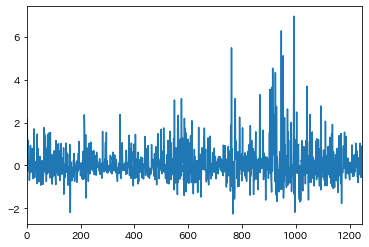

In [19]:
pos_df['profit'].plot()

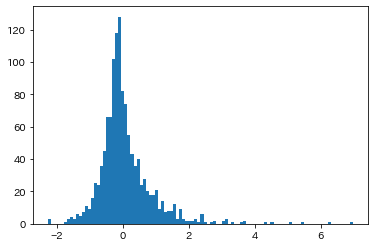

In [20]:
plt.hist(pos_df['profit'], bins=100)
plt.show()

In [21]:
pos_df.describe()

,entry_rate,exit_rate,profit
count,1245.000000,1245.000000,1245.000000
mean,97.823504,97.838106,0.066686
std,14.997820,15.001775,0.820739
min,75.658000,75.658000,-2.264000
25%,82.270000,82.270000,-0.348000
50%,99.876000,99.899000,-0.086000
75%,111.246000,111.246000,0.326000
max,125.008000,125.008000,6.967000


In [60]:
pos_df.sort_values(by='profit', ascending=False).head(10)

,date,entry_rate,exit_rate,profit
993,2016-11-16 16:00:00+00:00,102.362,109.337,6.967
946,2016-06-22 21:00:00+00:00,110.956,104.663,6.285
761,2014-11-06 04:00:00+00:00,108.888,114.386,5.490
953,2016-07-15 03:00:00+00:00,100.550,105.677,5.119
914,2016-02-11 10:00:00+00:00,116.744,112.195,4.541
924,2016-04-18 06:00:00+00:00,112.770,108.425,4.337
1042,2017-03-28 15:00:00+00:00,114.700,110.990,3.702
912,2016-02-05 13:00:00+00:00,120.664,117.002,3.654
904,2016-01-08 01:00:00+00:00,121.817,118.252,3.557
866,2015-08-27 15:00:00+00:00,124.364,121.052,3.304


### 3 2.5	M15

In [61]:
pos_count, profit, pos_df = back_test(K=2.5, start='2010-01-01-00-00-00', end='2018-12-31-00-00-00', gran='M15', ref=5)
print('pos_count: {}, profit: {}'.format(pos_count, profit))

pos_count: 2757, profit: 71.76300000000337


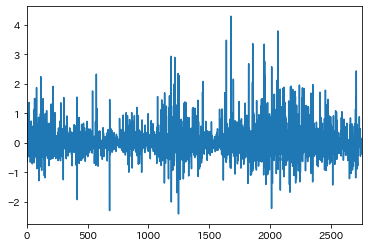

In [41]:
pos_df['profit'].plot()

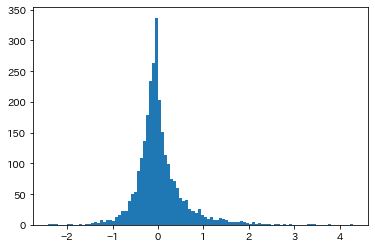

In [42]:
plt.hist(pos_df['profit'], bins=100)
plt.show()

In [43]:
pos_df.describe()

,entry_rate,exit_rate,profit
count,2756.000000,2756.000000,2756.000000
mean,97.933632,97.940118,0.026039
std,14.871448,14.873175,0.540462
min,75.543000,75.543000,-2.412000
25%,82.090750,82.090750,-0.233000
50%,101.325500,101.332000,-0.048500
75%,110.971250,110.971250,0.189000
max,125.168000,125.168000,4.285000


In [62]:
pos_df.sort_values(by='profit', ascending=False).head(10)

,date,entry_rate,exit_rate,profit
1679,2014-12-17 00:00:00+00:00,121.352,117.059,4.285
2066,2016-07-13 00:00:00+00:00,100.633,104.428,3.787
1642,2014-11-04 09:45:00+00:00,109.887,113.368,3.473
1859,2015-08-24 13:15:00+00:00,120.616,117.248,3.360
1953,2016-02-05 00:15:00+00:00,120.311,116.964,3.339
1188,2013-04-05 04:15:00+00:00,93.555,96.490,2.927
1218,2013-05-13 05:00:00+00:00,98.808,101.704,2.888
1957,2016-02-11 12:15:00+00:00,115.018,112.251,2.759
1826,2015-07-14 05:15:00+00:00,120.621,123.304,2.675
1825,2015-07-08 22:15:00+00:00,123.227,120.621,2.598


### 4 0.8	H8

In [63]:
pos_count, profit, pos_df = back_test(K=0.8, start='2010-01-01-00-00-00', end='2018-12-31-00-00-00', gran='H8', ref=5)
print('pos_count: {}, profit: {}'.format(pos_count, profit))

pos_count: 1430, profit: 70.30299999999912


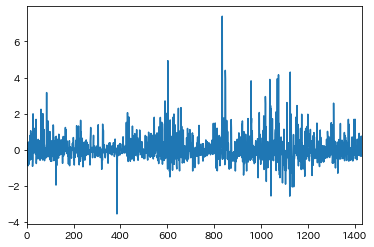

In [45]:
pos_df['profit'].plot()

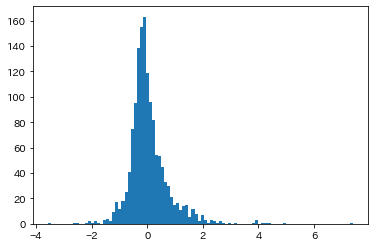

In [46]:
plt.hist(pos_df['profit'], bins=100)
plt.show()

In [47]:
pos_df.describe()

,entry_rate,exit_rate,profit
count,1429.000000,1429.000000,1429.000000
mean,98.615765,98.629371,0.049197
std,14.913166,14.915776,0.747410
min,75.658000,75.658000,-3.553000
25%,82.662000,82.662000,-0.336000
50%,101.676000,101.686000,-0.087000
75%,111.376000,111.376000,0.302000
max,125.640000,125.640000,7.394000


In [64]:
pos_df.sort_values(by='profit', ascending=False).head(10)

,date,entry_rate,exit_rate,profit
834,2014-11-07 06:00:00+00:00,107.826,115.228,7.394
602,2013-04-12 05:00:00+00:00,94.100,99.042,4.934
847,2014-12-16 14:00:00+00:00,120.810,116.405,4.397
1124,2016-11-14 22:00:00+00:00,103.923,108.230,4.299
1074,2016-07-15 13:00:00+00:00,101.192,105.352,4.152
848,2014-12-23 22:00:00+00:00,116.405,120.355,3.942
1069,2016-06-24 05:00:00+00:00,106.150,102.208,3.934
1037,2016-04-07 21:00:00+00:00,112.674,108.772,3.894
957,2015-08-24 21:00:00+00:00,123.414,119.591,3.815
85,2010-07-01 21:00:00+00:00,91.110,87.936,3.166


### 5 0.6	H12

In [65]:
pos_count, profit, pos_df = back_test(K=0.6, start='2010-01-01-00-00-00', end='2018-12-31-00-00-00', gran='H12', ref=5)
print('pos_count: {}, profit: {}'.format(pos_count, profit))

pos_count: 1466, profit: 70.04399999999966


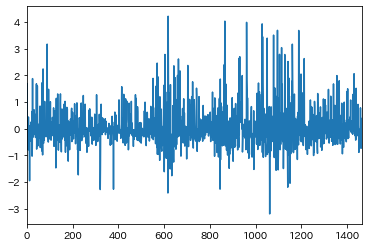

In [49]:
pos_df['profit'].plot()

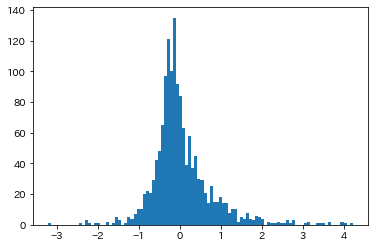

In [50]:
plt.hist(pos_df['profit'], bins=100)
plt.show()

In [51]:
pos_df.describe()

,entry_rate,exit_rate,profit
count,1465.000000,1465.000000,1465.000000
mean,98.714315,98.726955,0.047812
std,14.848616,14.851068,0.733790
min,75.888000,75.888000,-3.202000
25%,82.684000,82.684000,-0.328000
50%,101.794000,101.795000,-0.097000
75%,111.354000,111.354000,0.294000
max,125.378000,125.378000,4.217000


In [66]:
pos_df.sort_values(by='profit', ascending=False).head(10)

,date,entry_rate,exit_rate,profit
618,2013-04-11 09:00:00+00:00,95.450,99.675,4.217
866,2014-12-23 22:00:00+00:00,116.405,120.446,4.033
961,2015-08-24 21:00:00+00:00,123.414,119.418,3.988
1029,2016-02-07 22:00:00+00:00,120.682,116.744,3.930
1096,2016-07-12 21:00:00+00:00,100.633,104.330,3.689
1189,2017-03-22 21:00:00+00:00,114.738,111.046,3.684
1079,2016-06-05 21:00:00+00:00,110.687,107.170,3.509
1031,2016-02-11 10:00:00+00:00,115.857,112.401,3.448
1051,2016-04-07 21:00:00+00:00,112.343,108.940,3.395
89,2010-07-01 21:00:00+00:00,91.110,87.932,3.170


### 良いのか悪いのかわからん

In [71]:
pos_count, profit, pos_df = back_test(K=0.5, start='2010-01-01-00-00-00', end='2010-12-31-00-00-00', gran='H12', ref=5)
print('pos_count: {}, profit: {}'.format(pos_count, profit))

pos_count: 1709, profit: 88.74900000000167


In [72]:
pos_df.describe()

,entry_rate,exit_rate,profit
count,1708.00000,1708.000000,1708.000000
mean,98.86896,98.880920,0.051961
std,14.75133,14.754315,0.678686
min,75.88800,75.888000,-3.202000
25%,82.81150,82.811500,-0.292000
50%,101.86750,101.869500,-0.083000
75%,111.39625,111.399250,0.284250
max,125.37800,125.378000,4.217000


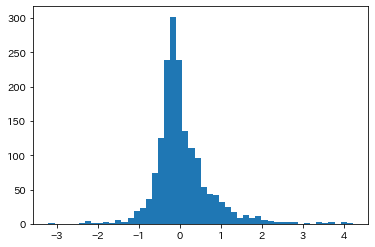

In [73]:
plt.hist(pos_df['profit'], bins=50)
plt.show()

### 改良(バックテスト2)

In [8]:
def get_evaluation(pos_df, return_=False):
    # 勝率
    win_c = pos_df[pos_df['pips'] >=0].shape[0]
    P = win_c / len(pos_df.index)
    # ペイオフレシオ
    win_p = mean(pos_df[pos_df['pips'] >=0]['pips'])
    los_p = mean(pos_df[pos_df['pips'] < 0]['pips']) * (-1)
    R = win_p / los_p
    # プロフィットファクター
    pf = pos_df[pos_df['profit']>0]['profit'].sum() / pos_df[pos_df['profit']<=0]['profit'].sum() * (-1)
    # 期待値
    win_pro = mean(pos_df[pos_df['pips'] >=0]['profit'])
    los_pro = mean(pos_df[pos_df['pips'] < 0]['profit']) * (-1)
    E = P * win_pro - pos_df[pos_df['pips'] < 0].shape[0] / len(pos_df.index) * los_pro
    # 最大ドローダウン
    dd = pos_df.sort_values(by='pips', ascending=True).head(1)['pips'].values[0]
    # ケリー基準
    kly = ((R + 1) * P - 1) / R
    if return_:
        # WP, POR, PF, E, DD, KLY
        return round(P*100, 2), round(R, 4), round(pf, 4), round(E, 3), round(dd, 1), round(kly*100, 2)
    else:
        print('勝率: {:.2f}%'.format(P*100))
        print('ペイオフレシオ: {:.4f}'.format(R))
        print('プロフィットファクター: {:.4f}'.format(pf))
        print('期待値: {:.3f}円'.format(E))
        print('最大ドローダウン: {:.1f}pips'.format(dd))
        print('ケリー基準: {:.2f}%'.format(kly*100))

In [17]:
# バックテスト2
def back_test2(df, inst, fee, seed_money, K, ref=5, lot=1000, kly_rate='None', print_=True):
    range_ = 0
    range_list = []
    ave_range = 0
    least_5 = 0
    pos = 'None'
    assets = seed_money
    tmp_i = 0
    lot_l = []
    l_or_s = []
    entry_date = []
    entry_rate_l = []
    exit_date = []
    exit_rate_l = []
    pips_l = []
    profit_l = []
    assets_l = []

    # 実行
    for i in range(len(df) - 1):
        rate = df.iat[i, 5] # 当日の終値
        next_rate = df.iat[i+1, 2] # シグナル点灯した次の足の始値
        range_ = round(df.iat[i, 3] - df.iat[i, 4], 3) # High - Low
        range_list.append(range_)
    
        if i > ref:
            least_m = round(mean(range_list[i-ref-1:i-1]) * K, 3)
            open_close = round(df.iat[i, 5] - df.iat[i, 2], 3) # Close - Open

            # 上昇トレンドと判断しロング
            if least_m < open_close:
                if pos == 'entry_long':
                    continue
                else:
                    # もし逆のポジションを持ってたら利確
                    if pos == 'entry_short':
                        exit_rate = next_rate
                        pips = (entry_rate - exit_rate - fee) * 100
                        if kly_rate != 'None':
                            kly = assets * kly_rate
                            lot = math.floor(kly / exit_rate)
                        profit = pips * lot / 100
                        assets = round(assets + profit, 4)
                        lot_l.extend([lot])
                        l_or_s.extend(['short'])
                        entry_date.extend([df.iat[tmp_i, 0]])
                        entry_rate_l.extend([entry_rate])
                        exit_date.extend([df.iat[i, 0]])
                        exit_rate_l.extend([exit_rate])
                        pips_l.extend([pips])
                        profit_l.extend([profit])
                        assets_l.extend([assets])
                        if assets < 0:
                            break
                    entry_rate = next_rate
                    pos = 'entry_long'
                    tmp_i = i
        
            # 下降トレンドと判断しショート
            if -least_m > open_close:
                if pos == 'entry_short':
                    continue
                else:
                    # もし逆のポジションを持ってたら利確
                    if pos == 'entry_long':
                        exit_rate = next_rate
                        pips = (exit_rate - entry_rate - fee) * 100
                        if kly_rate != 'None':
                            kly = assets * kly_rate
                            lot = math.floor(kly / exit_rate)
                        profit = pips * lot / 100
                        assets = round(assets + profit, 4)
                        lot_l.extend([lot])
                        l_or_s.extend(['long'])
                        entry_date.extend([df.iat[tmp_i, 0]])
                        entry_rate_l.extend([entry_rate])
                        exit_date.extend([df.iat[i, 0]])
                        exit_rate_l.extend([exit_rate])
                        pips_l.extend([pips])
                        profit_l.extend([profit])
                        assets_l.extend([assets])
                        if assets < 0:
                            break
                    entry_rate = next_rate
                    pos = 'entry_short'
                    tmp_i = i
    
    pos_df = pd.DataFrame(data={'lot': lot_l, 'l_or_s': l_or_s, 'entry_date': entry_date, 'entry_rate': entry_rate_l,
                                'exit_date': exit_date, 'exit_rate': exit_rate_l, 'pips': pips_l, 'profit': profit_l,
                                'assets':assets_l},
                          columns=['lot', 'l_or_s', 'entry_date', 'entry_rate', 'exit_date', 'exit_rate', 'pips', 'profit', 'assets'])
    if print_:
        print('pos count: {:>5}, assets: {:>6.0f}円'.format(pos_df.shape[0], pos_df.tail(1)['assets'].values[0]))
    return pos_df

In [36]:
# バックテスト3
def back_test3(df, inst, fee, seed_money, K, ref=5, lot=1000, kly_rate='None', print_=True):
    range_ = 0
    range_list = []
    ave_range = 0
    least_5 = 0
    pos = 'None'
    assets = seed_money
    tmp_i = 0
    lot_l = []
    l_or_s = []
    entry_date = []
    entry_rate_l = []
    exit_date = []
    exit_rate_l = []
    pips_l = []
    profit_l = []
    assets_l = []

    # 実行
    for i in range(len(df) - 1):
        rate = df.iat[i, 5] # 当日の終値
        next_rate = df.iat[i+1, 2] # シグナル点灯した次の足の始値
        range_ = round(df.iat[i, 3] - df.iat[i, 4], 3) # High - Low
        range_list.append(range_)
    
        if i > ref:
            least_m = round(mean(range_list[i-ref-1:i-1]) * K, 3)
            open_high = round(df.iat[i, 3] - df.iat[i, 2], 3) # High - Open
            open_low = round(df.iat[i, 2] - df.iat[i, 4], 3) # Open - Low

            # 上昇トレンドと判断しロング
            if least_m < open_high and open_low < open_high:
                if pos == 'entry_long':
                    continue
                else:
                    # もし逆のポジションを持ってたら利確
                    if pos == 'entry_short':
                        exit_rate = next_rate
                        pips = (entry_rate - exit_rate - fee) * 100
                        if kly_rate != 'None':
                            kly = assets * kly_rate
                            lot = floor(kly / exit_rate)
                        profit = pips * lot / 100
                        assets = round(assets + profit, 4)
                        lot_l.extend([lot])
                        l_or_s.extend(['short'])
                        entry_date.extend([df.iat[tmp_i, 0]])
                        entry_rate_l.extend([entry_rate])
                        exit_date.extend([df.iat[i, 0]])
                        exit_rate_l.extend([exit_rate])
                        pips_l.extend([pips])
                        profit_l.extend([profit])
                        assets_l.extend([assets])
                        if assets < 0:
                            break
                    entry_rate = next_rate
                    pos = 'entry_long'
                    tmp_i = i
        
            # 下降トレンドと判断しショート
            if least_m < open_low and open_high < open_low:
                if pos == 'entry_short':
                    continue
                else:
                    # もし逆のポジションを持ってたら利確
                    if pos == 'entry_long':
                        exit_rate = next_rate
                        pips = (exit_rate - entry_rate - fee) * 100
                        if kly_rate != 'None':
                            kly = assets * kly_rate
                            lot = floor(kly / exit_rate)
                        profit = pips * lot / 100
                        assets = round(assets + profit, 4)
                        lot_l.extend([lot])
                        l_or_s.extend(['long'])
                        entry_date.extend([df.iat[tmp_i, 0]])
                        entry_rate_l.extend([entry_rate])
                        exit_date.extend([df.iat[i, 0]])
                        exit_rate_l.extend([exit_rate])
                        pips_l.extend([pips])
                        profit_l.extend([profit])
                        assets_l.extend([assets])
                        if assets < 0:
                            break
                    entry_rate = next_rate
                    pos = 'entry_short'
                    tmp_i = i
    
    pos_df = pd.DataFrame(data={'lot': lot_l, 'l_or_s': l_or_s, 'entry_date': entry_date, 'entry_rate': entry_rate_l,
                                'exit_date': exit_date, 'exit_rate': exit_rate_l, 'pips': pips_l, 'profit': profit_l,
                                'assets':assets_l},
                          columns=['lot', 'l_or_s', 'entry_date', 'entry_rate', 'exit_date', 'exit_rate', 'pips', 'profit', 'assets'])
    if print_:
        print('pos count: {:>5}, assets: {:>6.0f}円'.format(pos_df.shape[0], pos_df.tail(1)['assets'].values[0]))
    return pos_df

In [16]:
# 足検証
inst_df = pd.DataFrame(columns=['K', 'gran', 'ref', 'pos_count', 'profit',
                                'WP(%)', 'POR', 'PF', 'E(円)', 'DD(pips)', 'KLY(%)'])
grans = ['M5', 'M15', 'M30', 'H1', 'H2', 'H3', 'H4', 'H6', 'H8', 'H12', 'D']
grans.reverse()
for gran in grans:
    df = get_data_super('2010-01-01-00-00-00', '2020-01-01-00-00-00', gran, inst='USD_JPY')
    for k in range(5, 25+1):
        K = round(k * 0.1, 2)
        for ref in range(2, 9):
            print('gran: {:>3}, K: {}, ref: {}, '.format(gran, K, ref), end='')
            pos_df = back_test2(df, 'USD_JPY', fee=0.008, seed_money=1000000, K=K, ref=ref, print_=False)
            pos_count, profit = pos_df.shape[0], pos_df['pips'].sum() / 100
            WP, POR, PF, E, DD, KLY = get_evaluation(pos_df, return_=True)
            print('pos count: {:>8}, profit: {:>10.3f}'.format(pos_count, profit))
            tmp_se = pd.Series([K, gran, ref, pos_count, profit, WP, POR, PF, E, DD, KLY], index=inst_df.columns)
            inst_df = inst_df.append(tmp_se, ignore_index=True)

gran:   D, K: 0.5, ref: 2, pos count:      592, profit:     25.249
gran:   D, K: 0.5, ref: 3, pos count:      559, profit:     26.940
gran:   D, K: 0.5, ref: 4, pos count:      563, profit:     17.979
gran:   D, K: 0.5, ref: 5, pos count:      536, profit:     27.047
gran:   D, K: 0.5, ref: 6, pos count:      534, profit:     17.332
gran:   D, K: 0.5, ref: 7, pos count:      532, profit:     11.029
gran:   D, K: 0.5, ref: 8, pos count:      540, profit:     -5.601
gran:   D, K: 0.6, ref: 2, pos count:      476, profit:     20.001
gran:   D, K: 0.6, ref: 3, pos count:      453, profit:     28.796
gran:   D, K: 0.6, ref: 4, pos count:      447, profit:     28.765
gran:   D, K: 0.6, ref: 5, pos count:      436, profit:     -1.135
gran:   D, K: 0.6, ref: 6, pos count:      440, profit:     -2.880
gran:   D, K: 0.6, ref: 7, pos count:      430, profit:     15.236
gran:   D, K: 0.6, ref: 8, pos count:      424, profit:      8.627
gran:   D, K: 0.7, ref: 2, pos count:      388, profit:     28

gran:   D, K: 2.2, ref: 5, pos count:       24, profit:     48.535
gran:   D, K: 2.2, ref: 6, pos count:       22, profit:     34.689
gran:   D, K: 2.2, ref: 7, pos count:       18, profit:     33.616
gran:   D, K: 2.2, ref: 8, pos count:       18, profit:     38.850
gran:   D, K: 2.3, ref: 2, pos count:       64, profit:     -3.029
gran:   D, K: 2.3, ref: 3, pos count:       44, profit:      2.264
gran:   D, K: 2.3, ref: 4, pos count:       28, profit:      9.728
gran:   D, K: 2.3, ref: 5, pos count:       18, profit:     35.559
gran:   D, K: 2.3, ref: 6, pos count:       16, profit:     24.833
gran:   D, K: 2.3, ref: 7, pos count:       16, profit:     41.883
gran:   D, K: 2.3, ref: 8, pos count:       14, profit:     25.391
gran:   D, K: 2.4, ref: 2, pos count:       55, profit:     23.863
gran:   D, K: 2.4, ref: 3, pos count:       38, profit:      3.822
gran:   D, K: 2.4, ref: 4, pos count:       20, profit:     39.409
gran:   D, K: 2.4, ref: 5, pos count:       18, profit:     29

gran: H12, K: 1.8, ref: 8, pos count:       76, profit:     20.421
gran: H12, K: 1.9, ref: 2, pos count:      149, profit:     11.002
gran: H12, K: 1.9, ref: 3, pos count:      123, profit:     32.110
gran: H12, K: 1.9, ref: 4, pos count:       81, profit:      3.245
gran: H12, K: 1.9, ref: 5, pos count:       74, profit:     25.379
gran: H12, K: 1.9, ref: 6, pos count:       72, profit:     12.935
gran: H12, K: 1.9, ref: 7, pos count:       66, profit:     21.399
gran: H12, K: 1.9, ref: 8, pos count:       67, profit:     14.611
gran: H12, K: 2.0, ref: 2, pos count:      137, profit:      9.700
gran: H12, K: 2.0, ref: 3, pos count:      101, profit:     52.576
gran: H12, K: 2.0, ref: 4, pos count:       71, profit:     26.759
gran: H12, K: 2.0, ref: 5, pos count:       72, profit:     14.293
gran: H12, K: 2.0, ref: 6, pos count:       64, profit:     22.713
gran: H12, K: 2.0, ref: 7, pos count:       64, profit:     -4.199
gran: H12, K: 2.0, ref: 8, pos count:       63, profit:     -7

gran:  H8, K: 1.5, ref: 4, pos count:      248, profit:     26.042
gran:  H8, K: 1.5, ref: 5, pos count:      235, profit:    -18.682
gran:  H8, K: 1.5, ref: 6, pos count:      210, profit:     -3.578
gran:  H8, K: 1.5, ref: 7, pos count:      194, profit:      8.497
gran:  H8, K: 1.5, ref: 8, pos count:      178, profit:      7.841
gran:  H8, K: 1.6, ref: 2, pos count:      264, profit:     29.505
gran:  H8, K: 1.6, ref: 3, pos count:      236, profit:      4.744
gran:  H8, K: 1.6, ref: 4, pos count:      218, profit:     38.166
gran:  H8, K: 1.6, ref: 5, pos count:      196, profit:     11.676
gran:  H8, K: 1.6, ref: 6, pos count:      176, profit:      4.816
gran:  H8, K: 1.6, ref: 7, pos count:      158, profit:     15.563
gran:  H8, K: 1.6, ref: 8, pos count:      144, profit:     27.523
gran:  H8, K: 1.7, ref: 2, pos count:      244, profit:     15.877
gran:  H8, K: 1.7, ref: 3, pos count:      216, profit:      9.754
gran:  H8, K: 1.7, ref: 4, pos count:      200, profit:     19

gran:  H6, K: 1.1, ref: 7, pos count:      615, profit:     -2.568
gran:  H6, K: 1.1, ref: 8, pos count:      599, profit:     -6.730
gran:  H6, K: 1.2, ref: 2, pos count:      630, profit:     17.251
gran:  H6, K: 1.2, ref: 3, pos count:      576, profit:     20.552
gran:  H6, K: 1.2, ref: 4, pos count:      541, profit:     21.728
gran:  H6, K: 1.2, ref: 5, pos count:      531, profit:     19.616
gran:  H6, K: 1.2, ref: 6, pos count:      515, profit:      9.200
gran:  H6, K: 1.2, ref: 7, pos count:      503, profit:      2.864
gran:  H6, K: 1.2, ref: 8, pos count:      503, profit:     -6.500
gran:  H6, K: 1.3, ref: 2, pos count:      548, profit:     30.499
gran:  H6, K: 1.3, ref: 3, pos count:      484, profit:     34.283
gran:  H6, K: 1.3, ref: 4, pos count:      449, profit:     43.414
gran:  H6, K: 1.3, ref: 5, pos count:      457, profit:     21.341
gran:  H6, K: 1.3, ref: 6, pos count:      447, profit:     20.468
gran:  H6, K: 1.3, ref: 7, pos count:      435, profit:      3

gran:  H4, K: 0.8, ref: 3, pos count:     1596, profit:     69.192
gran:  H4, K: 0.8, ref: 4, pos count:     1558, profit:     73.068
gran:  H4, K: 0.8, ref: 5, pos count:     1488, profit:     66.624
gran:  H4, K: 0.8, ref: 6, pos count:     1488, profit:     41.874
gran:  H4, K: 0.8, ref: 7, pos count:     1490, profit:     45.814
gran:  H4, K: 0.8, ref: 8, pos count:     1492, profit:     58.782
gran:  H4, K: 0.9, ref: 2, pos count:     1468, profit:     38.313
gran:  H4, K: 0.9, ref: 3, pos count:     1374, profit:     55.600
gran:  H4, K: 0.9, ref: 4, pos count:     1264, profit:     66.560
gran:  H4, K: 0.9, ref: 5, pos count:     1214, profit:     65.534
gran:  H4, K: 0.9, ref: 6, pos count:     1230, profit:     48.882
gran:  H4, K: 0.9, ref: 7, pos count:     1204, profit:     67.518
gran:  H4, K: 0.9, ref: 8, pos count:     1206, profit:     58.486
gran:  H4, K: 1.0, ref: 2, pos count:     1220, profit:     59.923
gran:  H4, K: 1.0, ref: 3, pos count:     1166, profit:     51

gran:  H4, K: 2.5, ref: 6, pos count:      159, profit:     18.314
gran:  H4, K: 2.5, ref: 7, pos count:      163, profit:     25.674
gran:  H4, K: 2.5, ref: 8, pos count:      149, profit:     23.218
gran:  H3, K: 0.5, ref: 2, pos count:     4002, profit:    -16.877
gran:  H3, K: 0.5, ref: 3, pos count:     3902, profit:      9.749
gran:  H3, K: 0.5, ref: 4, pos count:     3905, profit:    -28.057
gran:  H3, K: 0.5, ref: 5, pos count:     3888, profit:    -17.447
gran:  H3, K: 0.5, ref: 6, pos count:     3824, profit:     10.288
gran:  H3, K: 0.5, ref: 7, pos count:     3836, profit:      6.182
gran:  H3, K: 0.5, ref: 8, pos count:     3837, profit:     -6.512
gran:  H3, K: 0.6, ref: 2, pos count:     3266, profit:     10.141
gran:  H3, K: 0.6, ref: 3, pos count:     3134, profit:      4.185
gran:  H3, K: 0.6, ref: 4, pos count:     3093, profit:     -1.651
gran:  H3, K: 0.6, ref: 5, pos count:     3032, profit:     27.003
gran:  H3, K: 0.6, ref: 6, pos count:     3020, profit:     23

gran:  H3, K: 2.2, ref: 2, pos count:      382, profit:    -58.714
gran:  H3, K: 2.2, ref: 3, pos count:      313, profit:    -19.660
gran:  H3, K: 2.2, ref: 4, pos count:      298, profit:    -10.344
gran:  H3, K: 2.2, ref: 5, pos count:      290, profit:    -33.406
gran:  H3, K: 2.2, ref: 6, pos count:      280, profit:    -12.036
gran:  H3, K: 2.2, ref: 7, pos count:      244, profit:     -3.352
gran:  H3, K: 2.2, ref: 8, pos count:      250, profit:     12.728
gran:  H3, K: 2.3, ref: 2, pos count:      354, profit:    -43.096
gran:  H3, K: 2.3, ref: 3, pos count:      301, profit:    -26.888
gran:  H3, K: 2.3, ref: 4, pos count:      270, profit:    -12.396
gran:  H3, K: 2.3, ref: 5, pos count:      254, profit:    -11.326
gran:  H3, K: 2.3, ref: 6, pos count:      256, profit:    -10.108
gran:  H3, K: 2.3, ref: 7, pos count:      224, profit:      7.180
gran:  H3, K: 2.3, ref: 8, pos count:      230, profit:     -3.476
gran:  H3, K: 2.4, ref: 2, pos count:      324, profit:    -44

gran:  H2, K: 1.8, ref: 5, pos count:      632, profit:    -38.048
gran:  H2, K: 1.8, ref: 6, pos count:      611, profit:    -37.198
gran:  H2, K: 1.8, ref: 7, pos count:      594, profit:     -6.997
gran:  H2, K: 1.8, ref: 8, pos count:      565, profit:    -13.532
gran:  H2, K: 1.9, ref: 2, pos count:      709, profit:     14.224
gran:  H2, K: 1.9, ref: 3, pos count:      626, profit:    -18.110
gran:  H2, K: 1.9, ref: 4, pos count:      584, profit:    -47.782
gran:  H2, K: 1.9, ref: 5, pos count:      567, profit:    -25.430
gran:  H2, K: 1.9, ref: 6, pos count:      537, profit:    -23.960
gran:  H2, K: 1.9, ref: 7, pos count:      522, profit:     -5.053
gran:  H2, K: 1.9, ref: 8, pos count:      496, profit:      1.557
gran:  H2, K: 2.0, ref: 2, pos count:      637, profit:     -2.304
gran:  H2, K: 2.0, ref: 3, pos count:      566, profit:    -24.762
gran:  H2, K: 2.0, ref: 4, pos count:      526, profit:    -26.754
gran:  H2, K: 2.0, ref: 5, pos count:      506, profit:    -24

gran:  H1, K: 1.4, ref: 8, pos count:     1878, profit:      2.163
gran:  H1, K: 1.5, ref: 2, pos count:     2102, profit:      8.803
gran:  H1, K: 1.5, ref: 3, pos count:     1940, profit:      6.377
gran:  H1, K: 1.5, ref: 4, pos count:     1860, profit:      0.647
gran:  H1, K: 1.5, ref: 5, pos count:     1701, profit:      2.497
gran:  H1, K: 1.5, ref: 6, pos count:     1672, profit:      2.896
gran:  H1, K: 1.5, ref: 7, pos count:     1608, profit:     -0.710
gran:  H1, K: 1.5, ref: 8, pos count:     1606, profit:      1.612
gran:  H1, K: 1.6, ref: 2, pos count:     1850, profit:     16.775
gran:  H1, K: 1.6, ref: 3, pos count:     1696, profit:     15.313
gran:  H1, K: 1.6, ref: 4, pos count:     1596, profit:    -15.121
gran:  H1, K: 1.6, ref: 5, pos count:     1478, profit:     21.380
gran:  H1, K: 1.6, ref: 6, pos count:     1436, profit:      7.416
gran:  H1, K: 1.6, ref: 7, pos count:     1392, profit:      3.936
gran:  H1, K: 1.6, ref: 8, pos count:     1400, profit:      0

gran: M30, K: 1.1, ref: 4, pos count:     6788, profit:    -18.862
gran: M30, K: 1.1, ref: 5, pos count:     6660, profit:     -9.346
gran: M30, K: 1.1, ref: 6, pos count:     6546, profit:      5.062
gran: M30, K: 1.1, ref: 7, pos count:     6572, profit:     -8.168
gran: M30, K: 1.1, ref: 8, pos count:     6497, profit:     -6.900
gran: M30, K: 1.2, ref: 2, pos count:     6187, profit:     -5.236
gran: M30, K: 1.2, ref: 3, pos count:     5836, profit:    -21.588
gran: M30, K: 1.2, ref: 4, pos count:     5713, profit:      7.870
gran: M30, K: 1.2, ref: 5, pos count:     5553, profit:     17.712
gran: M30, K: 1.2, ref: 6, pos count:     5465, profit:      8.416
gran: M30, K: 1.2, ref: 7, pos count:     5413, profit:      6.748
gran: M30, K: 1.2, ref: 8, pos count:     5358, profit:     16.992
gran: M30, K: 1.3, ref: 2, pos count:     5269, profit:      0.432
gran: M30, K: 1.3, ref: 3, pos count:     4855, profit:     -8.590
gran: M30, K: 1.3, ref: 4, pos count:     4757, profit:     -5

gran: M15, K: 0.7, ref: 7, pos count:    32032, profit:   -345.008
gran: M15, K: 0.7, ref: 8, pos count:    31838, profit:   -334.764
gran: M15, K: 0.8, ref: 2, pos count:    27813, profit:   -264.004
gran: M15, K: 0.8, ref: 3, pos count:    26744, profit:   -276.761
gran: M15, K: 0.8, ref: 4, pos count:    25985, profit:   -267.814
gran: M15, K: 0.8, ref: 5, pos count:    25640, profit:   -246.847
gran: M15, K: 0.8, ref: 6, pos count:    25450, profit:   -271.268
gran: M15, K: 0.8, ref: 7, pos count:    25244, profit:   -255.298
gran: M15, K: 0.8, ref: 8, pos count:    25094, profit:   -258.756
gran: M15, K: 0.9, ref: 2, pos count:    22745, profit:   -249.250
gran: M15, K: 0.9, ref: 3, pos count:    21337, profit:   -237.604
gran: M15, K: 0.9, ref: 4, pos count:    20793, profit:   -238.998
gran: M15, K: 0.9, ref: 5, pos count:    20474, profit:   -227.025
gran: M15, K: 0.9, ref: 6, pos count:    20262, profit:   -204.679
gran: M15, K: 0.9, ref: 7, pos count:    20046, profit:   -201

gran: M15, K: 2.5, ref: 3, pos count:     1754, profit:     26.370
gran: M15, K: 2.5, ref: 4, pos count:     1653, profit:     15.547
gran: M15, K: 2.5, ref: 5, pos count:     1560, profit:      4.068
gran: M15, K: 2.5, ref: 6, pos count:     1524, profit:     39.914
gran: M15, K: 2.5, ref: 7, pos count:     1502, profit:     29.374
gran: M15, K: 2.5, ref: 8, pos count:     1470, profit:     18.720
gran:  M5, K: 0.5, ref: 2, pos count:    99260, profit:  -1000.013
gran:  M5, K: 0.5, ref: 3, pos count:   100018, profit:  -1000.011
gran:  M5, K: 0.5, ref: 4, pos count:    99381, profit:  -1000.017
gran:  M5, K: 0.5, ref: 5, pos count:    97760, profit:  -1000.001
gran:  M5, K: 0.5, ref: 6, pos count:    96175, profit:  -1000.001
gran:  M5, K: 0.5, ref: 7, pos count:    95326, profit:  -1000.017
gran:  M5, K: 0.5, ref: 8, pos count:    97225, profit:  -1000.001
gran:  M5, K: 0.6, ref: 2, pos count:    98332, profit:  -1000.051
gran:  M5, K: 0.6, ref: 3, pos count:    97364, profit:  -1000

limit_output extension: Maximum message size of 100000 exceeded with 100058 characters

In [19]:
# 足検証2
inst_df2 = pd.DataFrame(columns=['K', 'gran', 'pos_count', 'profit',
                                'WP(%)', 'POR', 'PF', 'E(円)', 'DD(pips)', 'KLY(%)'])
grans = ['M5', 'M15', 'M30', 'H1', 'H2', 'H3', 'H4', 'H6', 'H8', 'H12', 'D']
grans.reverse()
pos_list = []
for gran in grans:
    df = get_data_super('2010-01-01-00-00-00', '2020-01-01-00-00-00', gran, inst='USD_JPY')
    for k in range(5, 25+1):
        K = round(k * 0.1, 2)
        print('gran: {:>3}, K: {}, ref: {}, '.format(gran, K, ref), end='')
        pos_df = back_test3(df, 'USD_JPY', fee=0.008, seed_money=1000000, K=K, ref=5, print_=False)
        pos_count, profit = pos_df.shape[0], pos_df['pips'].sum() / 100
        WP, POR, PF, E, DD, KLY = get_evaluation(pos_df, return_=True)
        print('pos count: {:>8}, profit: {:>10.3f}'.format(pos_count, profit))
        tmp_se = pd.Series([K, gran, pos_count, profit, WP, POR, PF, E, DD, KLY], index=inst_df2.columns)
        inst_df2 = inst_df2.append(tmp_se, ignore_index=True)
        pos_list.append(pos_df)

gran:   D, K: 0.5, ref: 8, pos count:     1028, profit:     -1.587
gran:   D, K: 0.6, ref: 8, pos count:      874, profit:     14.053
gran:   D, K: 0.7, ref: 8, pos count:      734, profit:     22.463
gran:   D, K: 0.8, ref: 8, pos count:      576, profit:     46.639
gran:   D, K: 0.9, ref: 8, pos count:      508, profit:     27.113
gran:   D, K: 1.0, ref: 8, pos count:      432, profit:    -19.379
gran:   D, K: 1.1, ref: 8, pos count:      344, profit:    -14.003
gran:   D, K: 1.2, ref: 8, pos count:      284, profit:      1.141
gran:   D, K: 1.3, ref: 8, pos count:      238, profit:     14.689
gran:   D, K: 1.4, ref: 8, pos count:      196, profit:      6.535
gran:   D, K: 1.5, ref: 8, pos count:      174, profit:    -16.786
gran:   D, K: 1.6, ref: 8, pos count:      140, profit:    -12.276
gran:   D, K: 1.7, ref: 8, pos count:      120, profit:     -9.028
gran:   D, K: 1.8, ref: 8, pos count:      108, profit:     -2.676
gran:   D, K: 1.9, ref: 8, pos count:      100, profit:     -1

gran:  H3, K: 2.2, ref: 8, pos count:      516, profit:     -0.135
gran:  H3, K: 2.3, ref: 8, pos count:      468, profit:      2.827
gran:  H3, K: 2.4, ref: 8, pos count:      418, profit:      9.952
gran:  H3, K: 2.5, ref: 8, pos count:      372, profit:      8.742
gran:  H2, K: 0.5, ref: 8, pos count:    11115, profit:   -144.604
gran:  H2, K: 0.6, ref: 8, pos count:     9269, profit:   -105.534
gran:  H2, K: 0.7, ref: 8, pos count:     7581, profit:    -27.066
gran:  H2, K: 0.8, ref: 8, pos count:     6295, profit:     -3.414
gran:  H2, K: 0.9, ref: 8, pos count:     5203, profit:      4.048
gran:  H2, K: 1.0, ref: 8, pos count:     4279, profit:     18.984
gran:  H2, K: 1.1, ref: 8, pos count:     3555, profit:     38.954
gran:  H2, K: 1.2, ref: 8, pos count:     2983, profit:     35.049
gran:  H2, K: 1.3, ref: 8, pos count:     2535, profit:     33.650
gran:  H2, K: 1.4, ref: 8, pos count:     2191, profit:     14.818
gran:  H2, K: 1.5, ref: 8, pos count:     1862, profit:     -1

In [30]:
inst_df2.sort_values(by='profit', ascending=False).head(20)

,K,gran,pos_count,profit,WP(%),POR,PF,E(円),DD(pips),KLY(%)
21,0.5,H12,1909,91.490,41.28,1.7753,1.2479,47.926,-320.2,8.20
114,1.4,H3,1382,82.503,41.61,1.7715,1.2622,59.698,-226.4,8.64
209,2.5,M15,3046,77.346,41.10,1.6660,1.1627,25.393,-241.2,5.75
22,0.6,H12,1621,73.444,41.58,1.7003,1.2102,45.308,-320.2,7.22
45,0.8,H8,1579,68.956,41.99,1.6618,1.2028,43.671,-355.3,7.08
74,1.6,H6,538,68.165,44.80,1.6925,1.3734,126.701,-550.9,12.18
92,1.3,H4,1200,66.009,41.50,1.7400,1.2344,55.007,-355.3,7.88
113,1.3,H3,1656,65.137,40.88,1.7105,1.1829,39.334,-218.9,6.32
44,0.7,H8,1945,62.658,40.93,1.6808,1.1644,32.215,-355.3,5.78
93,1.4,H4,1008,62.153,41.77,1.7273,1.2388,61.660,-299.9,8.05


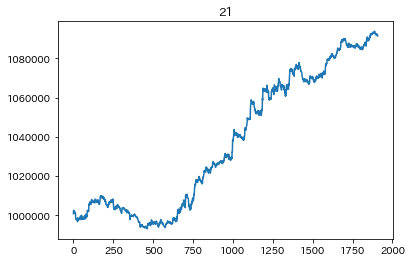

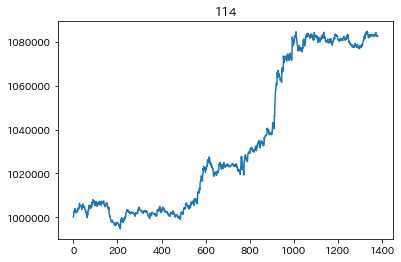

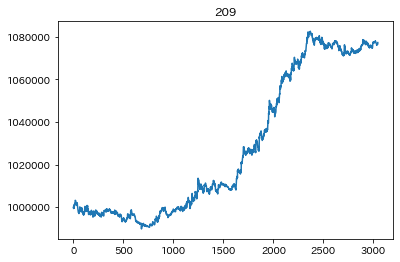

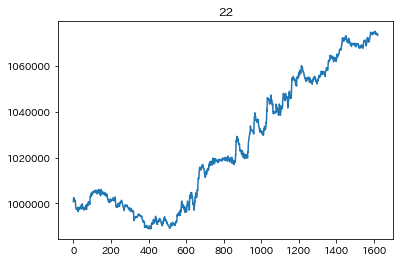

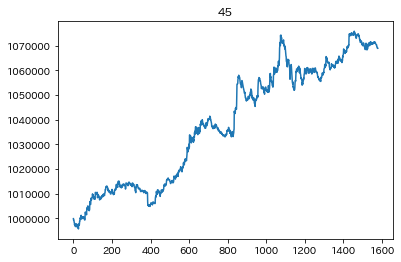

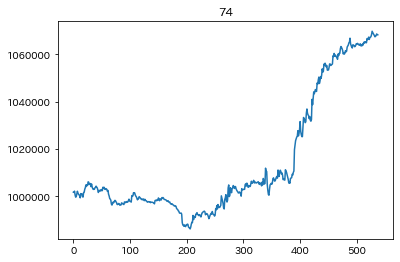

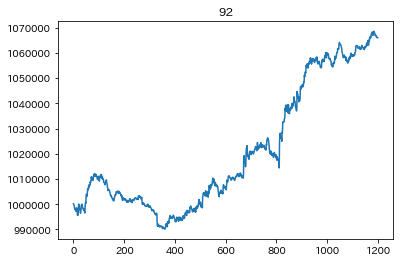

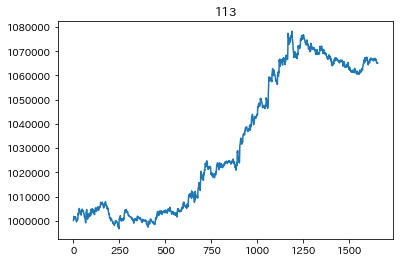

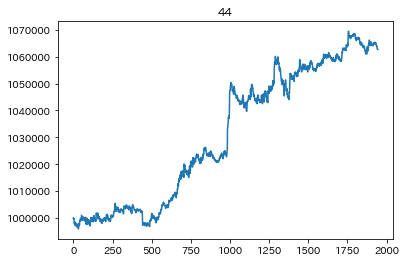

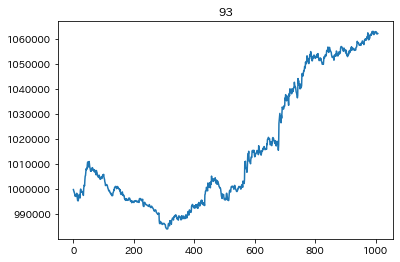

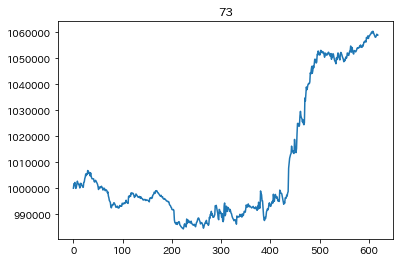

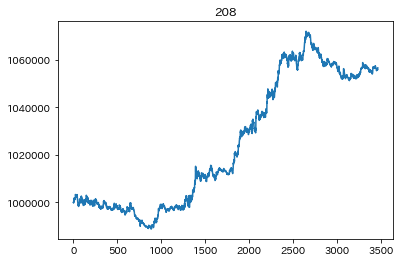

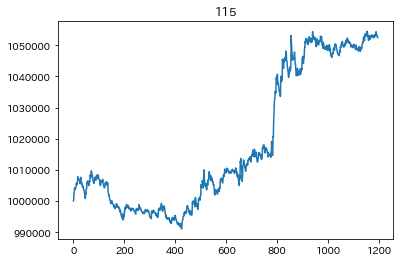

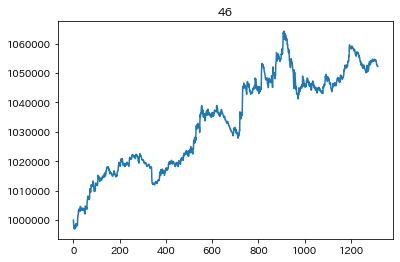

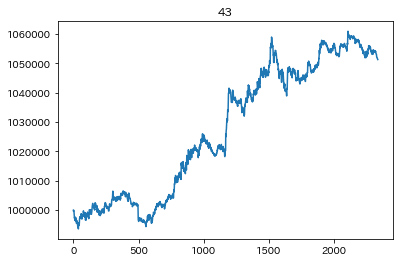

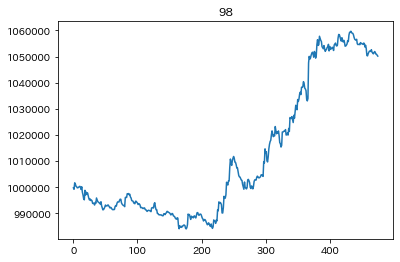

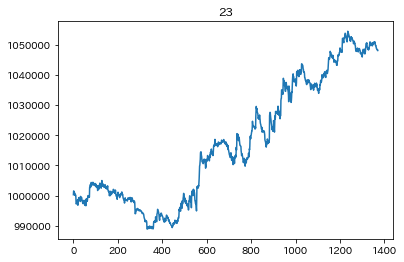

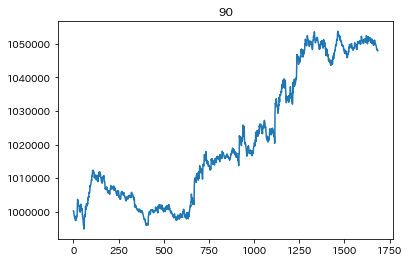

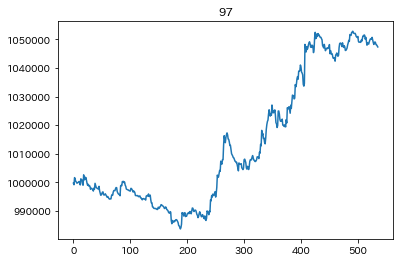

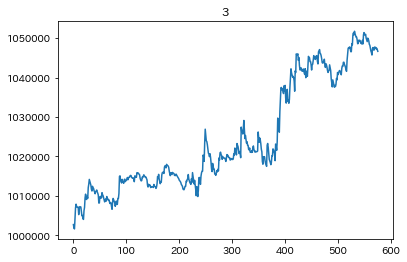

In [34]:
idx = inst_df2.sort_values(by='profit', ascending=False).head(20).index
for i in idx:
    plt.title(i)
    plt.plot(pos_list[i]['assets'])
    plt.show()

In [41]:
df = get_data_super('2010-01-01-00-00-00', '2020-01-01-00-00-00', gran='H6', inst='USD_JPY')
pos_df = back_test3(df, 'USD_JPY', fee=0.008, seed_money=1000000, K=1.6, ref=5, kly_rate=0.5)

pos count:   538, assets: 1330098円


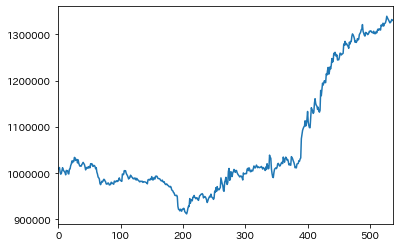

In [42]:
pos_df['assets'].plot()